# Analyze Visitor Movement Based on Estimated Occupancies in Three Interest Areas
This note shows how do we roughly estimate the trendency of visitors' movement based on estimations of occupancy in Three Interest Areas.

* To understand how do we divide video frames into Three Interest Areas which include Whole Interest Area, Core Interest Area and Margin Interest Area, please refer to [Video Processing: Division of Three Interest Areas](./Video%20Processing%20Division%20of%20Three%20Interest%20Areas.ipynb).
* To have a look on how do we use Openpose to get estimations of coccupancy, please refer to [Occupancy Estimation: Single Analysis for Three Interest Areas](./Occupancy%20Estimation%20Single%20Analysis%20for%20Three%20Interest%20Areas.ipynb).

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import math
from scipy.stats import mode

# Load Estimation of Occupancy Calculated by Openpose

In [2]:
occupancy_whole = pd.read_csv('test_video_processed_occupancy_whole.csv', sep=',')
occupancy_core = pd.read_csv('test_video_processed_occupancy_core.csv', sep=',')
occupancy_margin = pd.read_csv('test_video_processed_occupancy_margin.csv', sep=',')

<IPython.core.display.Javascript object>


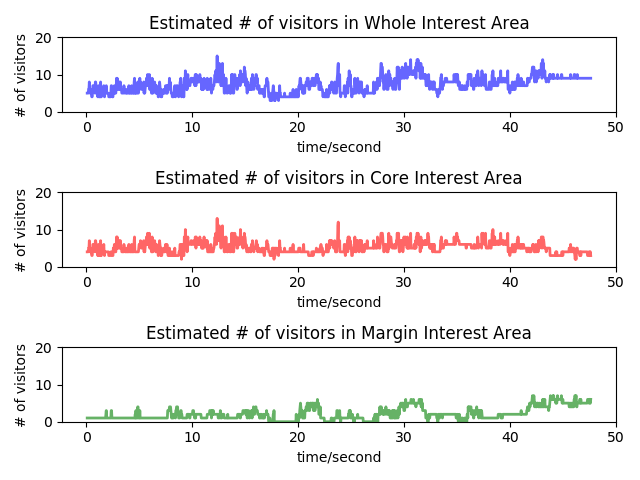

In [3]:
plt.figure()
# Whole Interest Area
plt.subplot(3, 1, 1)
plt.plot(occupancy_whole['Time']/1000, occupancy_whole['Occupancy'], 'b-', lw=2, alpha=0.6)
plt.xlabel('time/second')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Estimated # of visitors in Whole Interest Area')
#plt.grid(True)

# Core Interest Area
plt.subplot(3, 1, 2)
plt.plot(occupancy_core['Time']/1000, occupancy_core['Occupancy'], 'r-', lw=2, alpha=0.6)
plt.xlabel('time/second')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Estimated # of visitors in Core Interest Area')
#plt.grid(True)

# Margin Interest Area
plt.subplot(3, 1, 3)
plt.plot(occupancy_margin['Time']/1000, occupancy_margin['Occupancy'], 'g-', lw=2, alpha=0.6)
plt.xlabel('time/second')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Estimated # of visitors in Margin Interest Area')
#plt.grid(True)

plt.tight_layout()
plt.show()

## Compare Estimated Occupancy in Whole Interest Area and the Sum of Estimated Occupancies in Core and Margin Area 
The reason we show this is because previously we estimate occupancy independently in each of Three Interest Areas, which shows inconsistent results in where the sum of occupancy in Core and Margin Interest Area is not equal to the occupancy in Whole Interest area. However, in this version we infer occupancy from the number of visitors in Whole Interest Area and in Core Interest Area, which makes sure consistence.

<IPython.core.display.Javascript object>


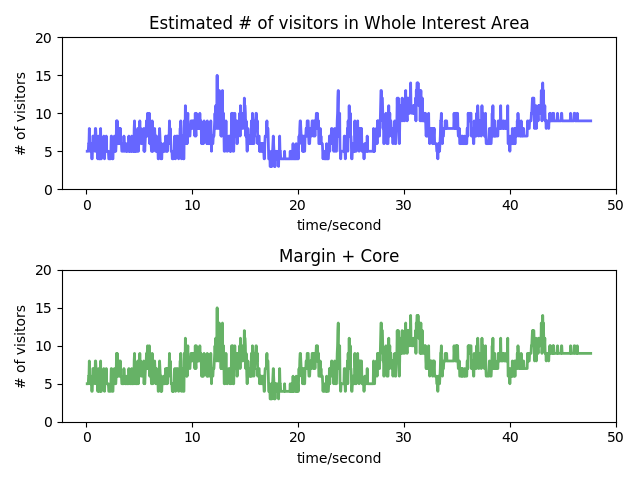

In [4]:
plt.figure()
# Whole Interest Area
plt.subplot(2,1,1)
plt.plot(occupancy_whole['Time']/1000, occupancy_whole['Occupancy'], 'b-', lw=2, alpha=0.6)
plt.xlabel('time/second')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Estimated # of visitors in Whole Interest Area')
# Margin + Core Interest Area
plt.subplot(2,1,2)
plt.plot(occupancy_margin['Time']/1000, occupancy_margin['Occupancy']+occupancy_core['Occupancy'], 'g-', lw=2, alpha=0.6)
plt.xlabel('time/second')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Margin + Core')
#plt.grid(True)

plt.tight_layout()
plt.show()

The time interval between two estimates is around 33 millisedonds. Thus, if we assume people will stay at the same place within one second. We can average over a sliding window of size 30.

In [5]:
print('The time interval between two estimates: {} milliseconds'.format(occupancy_whole['Time'][1]-occupancy_whole['Time'][0]))

The time interval between two estimates: 33.3326330532213 milliseconds


# Smoothen Estimations of # of Visitors in Three Areas calculated by Openpose

## Sliding Window Smoothing Method (self-defined)

In [6]:
import pdb
def moving_smoothing(values, window_size, smooth_type='mode', stride = 1):
    """
    Smoothen estimated occupancy.
    Args:
        values (pandas.DataFrame): 
            values['Time']: time in millisecond
            values['Occupancy']: estimated # of visitors
        window_size(int): the size of sliding window
        smooth_type (string): 
            1. 'mode'
            2. 'mean'
            3. 'min'
            4. 'median'
        stride (int): the stride between two consecutive windows
    Returns:
        smooth_time (np.array): smooth time i.e. the max time in each window
        smooth_occupancy (np.array): smooth occupancy i.e. the mode occupancy in each window
    """
    group_time = []
    group_occupancy = []
    for i in range(0, math.ceil((len(values['Time'])-window_size+1)/stride)):
        group_time.append(values['Time'][i:i+window_size])
        group_occupancy.append(values['Occupancy'][i:i+window_size])
    
    smooth_time = []
    smooth_occupancy = []
    for i in range(len(group_time)):
        smooth_time.append(min(group_time[i])) # max time in the group
        if smooth_type == 'mode':
            smooth_occupancy.append(mode(group_occupancy[i])[0][0]) # mode occupancy in the group
        elif smooth_type == 'mean':
            smooth_occupancy.append(np.round(np.mean(group_occupancy[i])))
        elif smooth_type == 'min':
            smooth_occupancy.append(np.round(np.min(group_occupancy[i])))
        elif smooth_type == 'median':
            smooth_occupancy.append(np.round(np.median(group_occupancy[i])))
        else:
            print('Please choose a proper smooth_type.')
    return np.array(smooth_time), np.array(smooth_occupancy)

In [7]:
window_size = 25
smooth_type='mean'
stride = 1

<IPython.core.display.Javascript object>


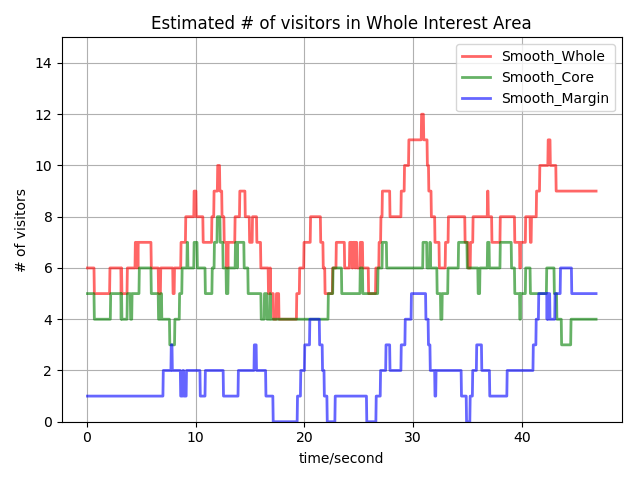

In [8]:
smooth_time_whole, smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_time_core, smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_time_margin, smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)

plt.figure()
# Whole Interest Area
plt.plot(smooth_time_whole/1000, smooth_occupancy_whole, 'r-', lw=2, alpha=0.6)
# Core Interest Area
plt.plot(smooth_time_core/1000, smooth_occupancy_core, 'g-', lw=2, alpha=0.6)
# Margin Interest Area
plt.plot(smooth_time_margin/1000, smooth_occupancy_margin, 'b-', lw=2, alpha=0.6)
plt.legend(('Smooth_Whole','Smooth_Core','Smooth_Margin'))

plt.xlabel('time/second')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=15)
plt.title('Estimated # of visitors in Whole Interest Area')
plt.grid(True)

plt.tight_layout()
plt.show()

### Compare
1. subplot 1: First add seperate estimations of core and margin, then smoothen
2. subplot 2: First smoothen estimateions of core and margin seperatively, then add smoothened estimations together.

<IPython.core.display.Javascript object>


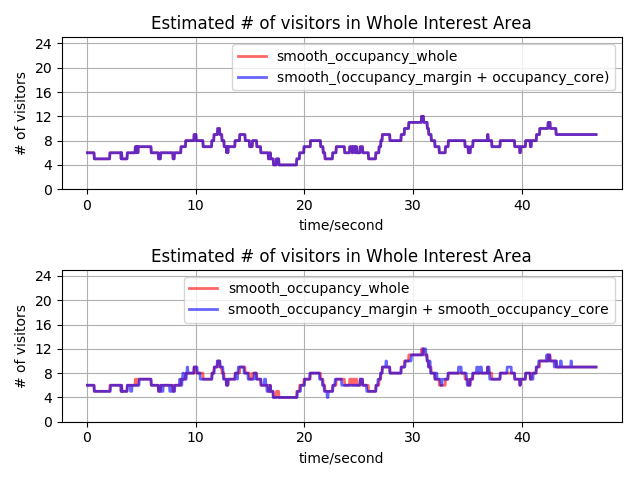

In [9]:
plt.figure()

# Add then Smoothen
plt.subplot(2,1,1)
smooth_time_whole, smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
occupancy_margin_add_core = occupancy_whole
occupancy_margin_add_core['Occupancy'] = occupancy_core['Occupancy'] + occupancy_margin['Occupancy']
smooth_time_margin_add_core, smooth_occupancy_margin_add_core = moving_smoothing(occupancy_margin_add_core, window_size, smooth_type)

# Whole Interest Area
plt.plot(smooth_time_whole/1000, smooth_occupancy_whole, 'r-', lw=2, alpha=0.6)
# Core and Margin Interest Area
plt.plot(smooth_time_margin_add_core/1000, smooth_occupancy_margin_add_core, 'b-', lw=2, alpha=0.6)
plt.legend(('smooth_occupancy_whole','smooth_(occupancy_margin + occupancy_core)'))
plt.xlabel('time/second')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=25)
plt.yticks(np.arange(0,25,step=4))
plt.title('Estimated # of visitors in Whole Interest Area')
plt.grid(True)

# Smoothen then Add
plt.subplot(2,1,2)
smooth_time_whole, smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_time_core, smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_time_margin, smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)

# Whole Interest Area
plt.plot(smooth_time_whole/1000, smooth_occupancy_whole, 'r-', lw=2, alpha=0.6)
# Core Interest Area
plt.plot(smooth_time_whole/1000, smooth_occupancy_core+smooth_occupancy_margin, 'b-', lw=2, alpha=0.6)
plt.legend(('smooth_occupancy_whole','smooth_occupancy_margin + smooth_occupancy_core'))
plt.xlabel('time/second')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=25)
plt.yticks(np.arange(0,25,step=4))
plt.title('Estimated # of visitors in Whole Interest Area')
plt.grid(True)

plt.tight_layout()
plt.show()

# Analyze Visitors' Movement

## Senario Truth Value Table

Assumption: 
1. There is a time-delay for visitors to move from one area to another area.
2. At the same time step: z = x+y
3. Estimate of # of visitors in each area is independent from each other.

**First three columns** correspond the variation tendency of the number of visitors in three area i.e. Core, Margin and Whole Interest Area. 
The codes for three variation tendencies are:
* 0: hold
* 1: increase
* 2: decrease

The **forth column** indicates whether the senario possible in reality assuming the estimates of the number of visitors in three areas are accurate. Sepcifically,
* 0: impossible senario
* 1: possible senarios

The **fifth column** gives [explanation on the senario](https://github.com/UWaterloo-ASL/Openpose-Video-Analysis/blob/master/docs/Truth%20Value%20Table.pdf).

* 27 combinations
   * only 13 of 27 combinations are possible
      * only 4 of the 13 possible cases in where new visitors come in.
      * only 6 of the 13 possible cases in where visitors leave from the whole interest area.
      * Only 3 of the 13 possible cases in where the # of visitors remain unchanged.

If we have this Truth Table, and we can estimate the change of the # of visitors in each area of two consecutive time steps, we can infer which scenario is happening.


In [10]:
senarios_truth_table = pd.read_csv('analize_visitor_in_and_out_senario_truth_table.csv')
senarios_truth_table

,# of visitors in core area: x,# of visitors in margin: y,# of visitors in whole interest area: z,Truth value,Explanation
0,0,0,0,1,No people transform between space.
1,0,0,1,0,Impossible
2,0,0,2,0,Impossible
3,0,1,0,0,Impossible
4,0,1,1,0,New people come in
5,0,1,2,0,Impossible
6,0,2,0,0,Impossible
7,0,2,1,0,Impossible
8,0,2,1,1,People get out
9,1,0,0,0,Impossible


## Define function to interpret senario from occupancy estimations in Core, Margin and Whole Interest areas.

In [11]:
def interpret_senario(occupancy_core, occupancy_margin, occupancy_whole, senarios_truth_table):
    """
    Args:
        occupancy_core (list): estimation of coccupancy in core intrest area
        occupancy_margin (list): estimation of coccupancy in margin intrest area
        occupancy_whole (list): estimation of coccupancy in whole intrest area
        senarios_truth_table (pandas.DataFrame): senarios truth table which has information on
            how to interpret senario.
    Returns:
        senario_sequence (list of string):
        event_sequence (list of int):
        event_time (list of int):
    """
    senario_sequence = []
    event_sequence = []
    event_time = []
    for i in range(len(smooth_occupancy_core)-1):
        change_x = occupancy_core[i+1] - occupancy_core[i]
        change_y = occupancy_margin[i+1] - occupancy_margin[i]
        change_z = occupancy_whole[i+1] - occupancy_whole[i]
        # code: 
        #    0: hold
        #    1: increase
        #    2: decrease
        if change_x == 0:
            x = 0
        elif change_x > 0:
            x = 1
        elif change_x < 0:
            x = 2

        if change_y == 0:
            y = 0
        elif change_y > 0:
            y = 1
        elif change_y < 0:
            y = 2

        if change_z == 0:
            z = 0
        elif change_z > 0:
            z = 1
        elif change_z < 0:
            z = 2
        # convert ternary to decimal
        senario_index = z + y*3 + x*3^2
        senario_sequence.append(senarios_truth_table['Explanation'][senario_index])
        if senarios_truth_table['Truth value'][senario_index] == 0:
            event_sequence.append(0)
        else:
            event_sequence.append(senario_index)
        event_time.append(i)
    return senario_sequence, event_sequence, event_time

## Sliding Window Smoothing

### mean

In [12]:
window_size = 25
smooth_type='mean'
stride = 1
smooth_time_whole, smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_time_core, smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_time_margin, smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)

<IPython.core.display.Javascript object>


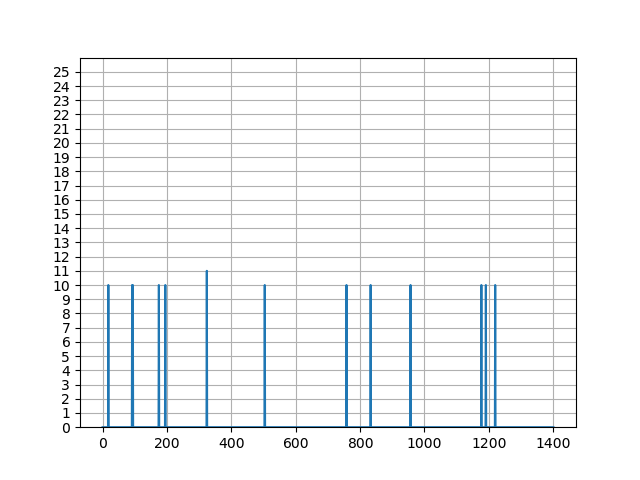

In [13]:
senario_sequence, event_sequence, event_time = interpret_senario(smooth_occupancy_core, smooth_occupancy_margin, smooth_occupancy_whole, senarios_truth_table)

plt.figure()
plt.plot(np.arange(len(event_sequence)), event_sequence)
plt.ylim(ymin=0, ymax=26)
plt.yticks(np.arange(0,26,step=1))
plt.grid(True)

In [14]:
interesting_event_count = 1
for time_index in event_time:
    if event_sequence[time_index] != 0:
        print('Detected interesting event: {},    Time: {}s'.format(interesting_event_count,occupancy_whole['Time'][time_index]/1000))
        print('Explanation: {}'.format(senario_sequence[time_index]))
        print('*****************************************************')
        interesting_event_count += 1

Detected interesting event: 1,    Time: 0.6666526610644258s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 2,    Time: 3.1332675070028007s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 3,    Time: 3.1999327731092437s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 4,    Time: 5.899876050420168s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 5,    Time: 6.566528711484593s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 6,    Time: 10.86643837535014s
Exp

### mode

In [15]:
window_size = 25
smooth_type='mode'
stride = 1
smooth_time_whole, smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_time_core, smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_time_margin, smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)

<IPython.core.display.Javascript object>


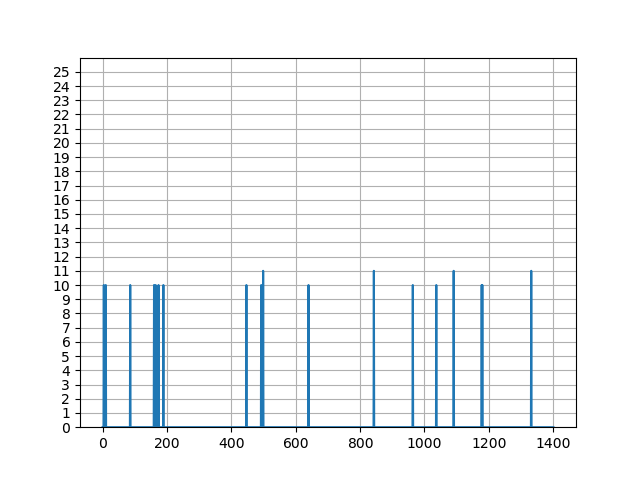

In [16]:
senario_sequence, event_sequence, event_time = interpret_senario(smooth_occupancy_core, smooth_occupancy_margin, smooth_occupancy_whole, senarios_truth_table)

plt.figure()
plt.plot(np.arange(len(event_sequence)), event_sequence)
plt.ylim(ymin=0, ymax=26)
plt.yticks(np.arange(0,26,step=1))
plt.grid(True)

In [17]:
interesting_event_count = 1
for time_index in event_time:
    if event_sequence[time_index] != 0:
        print('Detected interesting event: {},    Time: {}s'.format(interesting_event_count,occupancy_whole['Time'][time_index]/1000))
        print('Explanation: {}'.format(senario_sequence[time_index]))
        print('*****************************************************')
        interesting_event_count += 1

Detected interesting event: 1,    Time: 0.19999579831932768s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 2,    Time: 0.39999159663865536s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 3,    Time: 2.9332717086834728s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 4,    Time: 5.399886554621848s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 5,    Time: 5.566549719887956s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 6,    Time: 5.8665434173669455s


### min

In [18]:
window_size = 25
smooth_type='min'
stride = 1
smooth_time_whole, smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_time_core, smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_time_margin, smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)

<IPython.core.display.Javascript object>


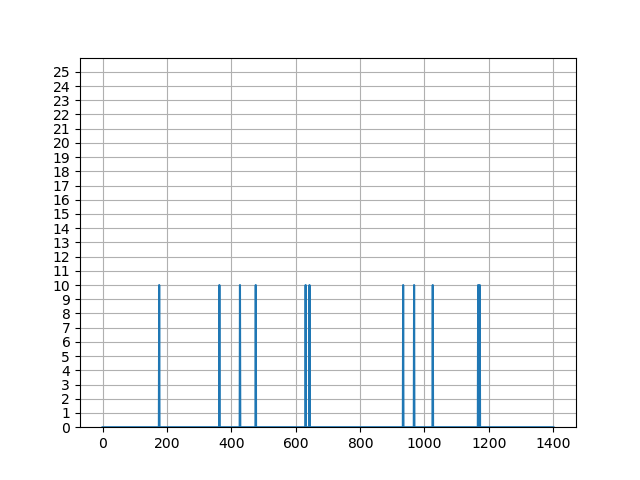

In [19]:
senario_sequence, event_sequence, event_time = interpret_senario(smooth_occupancy_core, smooth_occupancy_margin, smooth_occupancy_whole, senarios_truth_table)

plt.figure()
plt.plot(np.arange(len(event_sequence)), event_sequence)
plt.ylim(ymin=0, ymax=26)
plt.yticks(np.arange(0,26,step=1))
plt.grid(True)

In [20]:
interesting_event_count = 1
for time_index in event_time:
    if event_sequence[time_index] != 0:
        print('Detected interesting event: {},    Time: {}s'.format(interesting_event_count,occupancy_whole['Time'][time_index]/1000))
        print('Explanation: {}'.format(senario_sequence[time_index]))
        print('*****************************************************')
        interesting_event_count += 1

Detected interesting event: 1,    Time: 5.9332086834733895s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 2,    Time: 12.166411064425771s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 3,    Time: 14.29969957983193s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 4,    Time: 15.932998599439776s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 5,    Time: 21.099556722689076s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 6,    Time: 21.49954831932773s
Ex

### median

In [21]:
window_size = 25
smooth_type='median'
stride = 1
smooth_time_whole, smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_time_core, smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_time_margin, smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)

<IPython.core.display.Javascript object>


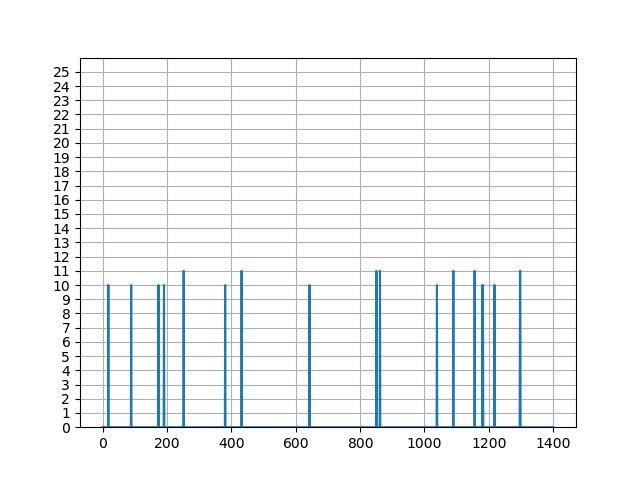

In [22]:
senario_sequence, event_sequence, event_time = interpret_senario(smooth_occupancy_core, smooth_occupancy_margin, smooth_occupancy_whole, senarios_truth_table)

plt.figure()
plt.plot(np.arange(len(event_sequence)), event_sequence)
plt.ylim(ymin=0, ymax=26)
plt.yticks(np.arange(0,26,step=1))
plt.grid(True)

In [23]:
interesting_event_count = 1
for time_index in event_time:
    if event_sequence[time_index] != 0:
        print('Detected interesting event: {},    Time: {}s'.format(interesting_event_count,occupancy_whole['Time'][time_index]/1000))
        print('Explanation: {}'.format(senario_sequence[time_index]))
        print('*****************************************************')
        interesting_event_count += 1

Detected interesting event: 1,    Time: 0.6666526610644258s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 2,    Time: 3.0332696078431374s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 3,    Time: 5.8665434173669455s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 4,    Time: 6.433198179271709s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 5,    Time: 8.466488795518208s
Explanation: People move from margin to core area and more people in margin get out of whole interest area.
*****************************************************
Detected interesting event: 

# Check on Video
To check the video, please go to [YouTube: test video processed](https://youtu.be/1iPKDs9P1i4).
1. If we look at the video, we might find that moving from one interesting area to another for people might take less than one second or even less than half second.
2. One big probelm is the estimation results from Openpose is not so reliable.